# Pricing equity options
In this notebook I price American equity options using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org) and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/). Since the lifetime of an option is usually measured using trading
days rather than calendar days, I make use of [the pandas-market-calendars library](https://pandas-market-calendars.readthedocs.io/en/latest/index.html) to get correct trading calendars.

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader, yfinance, and pandas-market-calendars
# !pip install pandas-datareader -U
# !pip install yfinance -U
# !pip install pandas-market-calendars -U

## Constructing a riskless spot rate curve for USD
Since I already covered it in a separate notebook, I will simply import it (along with all imports that this notebook needs). The resultant `YieldCurve` object is assigned to the `curve` variable.

I prepared two alternative rislless rate/yield curves &mdash; one based on US Treasury Yields converted into spot rates (you can use it for pricing options maturing up to 30 years in the future) and another based on AMERIBOR rates (you can use it for pricing options maturing up to 2 years in the future). Since AMERIBOR term structure is no longer published by the Federal Reserve Bank of St. Louis, it cannot be used anymore unfortunately...

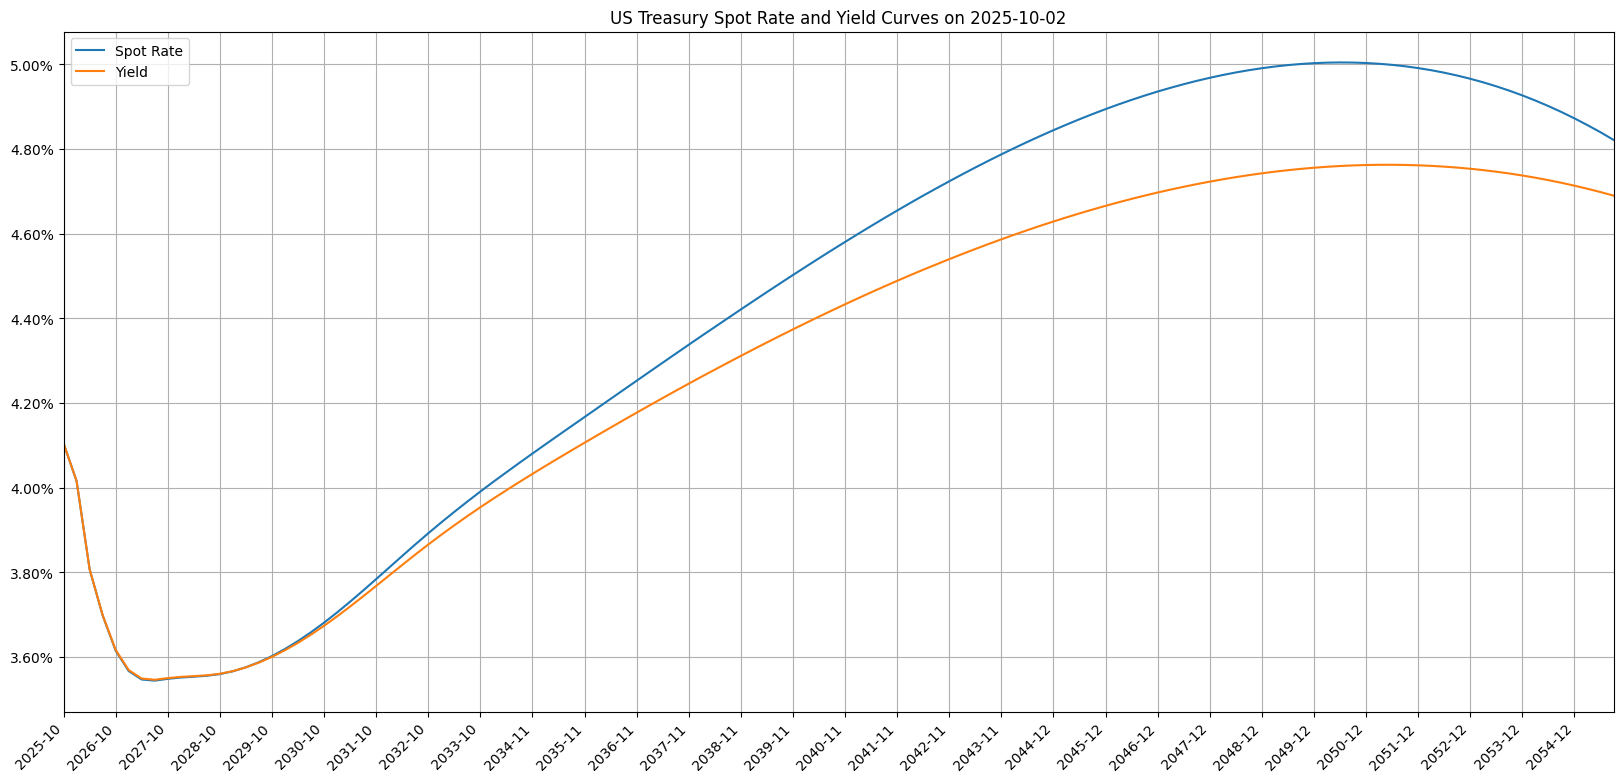

In [2]:
# Uncomment the below line if you want to price with a yield curve based on US Treasury Yields
%run riskless-spot-rate-curve-construction-example.ipynb

# Uncomment the below line if you want to price with a yield curve based on AMERIBOR rates
#%run riskless-rate-curve-construction-ameribor.ipynb

## Estimating and forecasting volatility of the stock, options on which we want to price
Now that the riskless spot rate curve (aka zero-rate curve) has been constructed, the next thing to do is obtain an accurate volatility estimate for the stock whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate its parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x.

Constraint optimization for three variables is not fast. If you are not content with the speed of `volatility.parameter_estimators.GARCHParameterEstimator`, you can use its `volatility.parameter_estimators.GARCHVarianceTargetingParameterEstimator` counterpart. This latter class is 
faster because it uses the so-called _variance targeting_ method whereby it sets ω based on the sample variance of price changes. Then it optimises for only two variables instead of three as GARCHParameterEstimator does. It's marginally less accurate.

*NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for Apple
Since volatility tends to change with time, it's recommended to estimate it based on the most recent 90 or 180 days, or on the same number of days as the duration of the option being priced. In this notebook I use date from the past two years.

In [3]:
TICKER = 'AAPL'

# I'll use price changes over the past two years to estimate GARCH(1, 1) ω, α, and β parameters
start = BDay(1).rollback(date.today() - relativedelta(years=+2))
ticker = yfin.Ticker(TICKER)

data = ticker.history(start=start, actions=False, auto_adjust=False).tz_localize(None)

asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

Objective function: 3630.57646 after 53 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000053699667, α=0.14819, β=0.66317


##### Optional: Estimating with a faster estimator &mdash; GARCHVarianceTargetingParameterEstimator

In [4]:
var_target_vol_estimator = parameter_estimators.GARCHVarianceTargetingParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (var_target_vol_estimator.omega, var_target_vol_estimator.alpha, var_target_vol_estimator.beta))

/usr/local/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Objective function: 3630.25986 after 41 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000052622715, α=0.16230, β=0.66678


As you can see, `GARCHParameterEstimator` is able to achieve a slightly higher value of the objective function than `GARCHVarianceTargetingParameterEstimator`. The higher, the more accurate as we are solving for the maximum value.

#### Forecasting volatility for Apple
Now that we have obtained the optimal GARCH(1, 1) for  parameter values&mdash;ω, α, and β&mdash;we can proceed to forecast the volatility of Apple stock. I have created the `volatility.parameter_estimators.GARCHVolatilityTracker` class to assist with this.

In [5]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for next January options, i.e. maturity on the 3rd Friday of next January
from dateutil.relativedelta import FR
maturity_date = curve.date + relativedelta(years=1, month=1, day=1, weekday=FR(3))
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of AAPL for term 0.2795 years: 0.26453


#### Optional: Visualizing historical and future volatility of Apple stock for 200 business days into the future

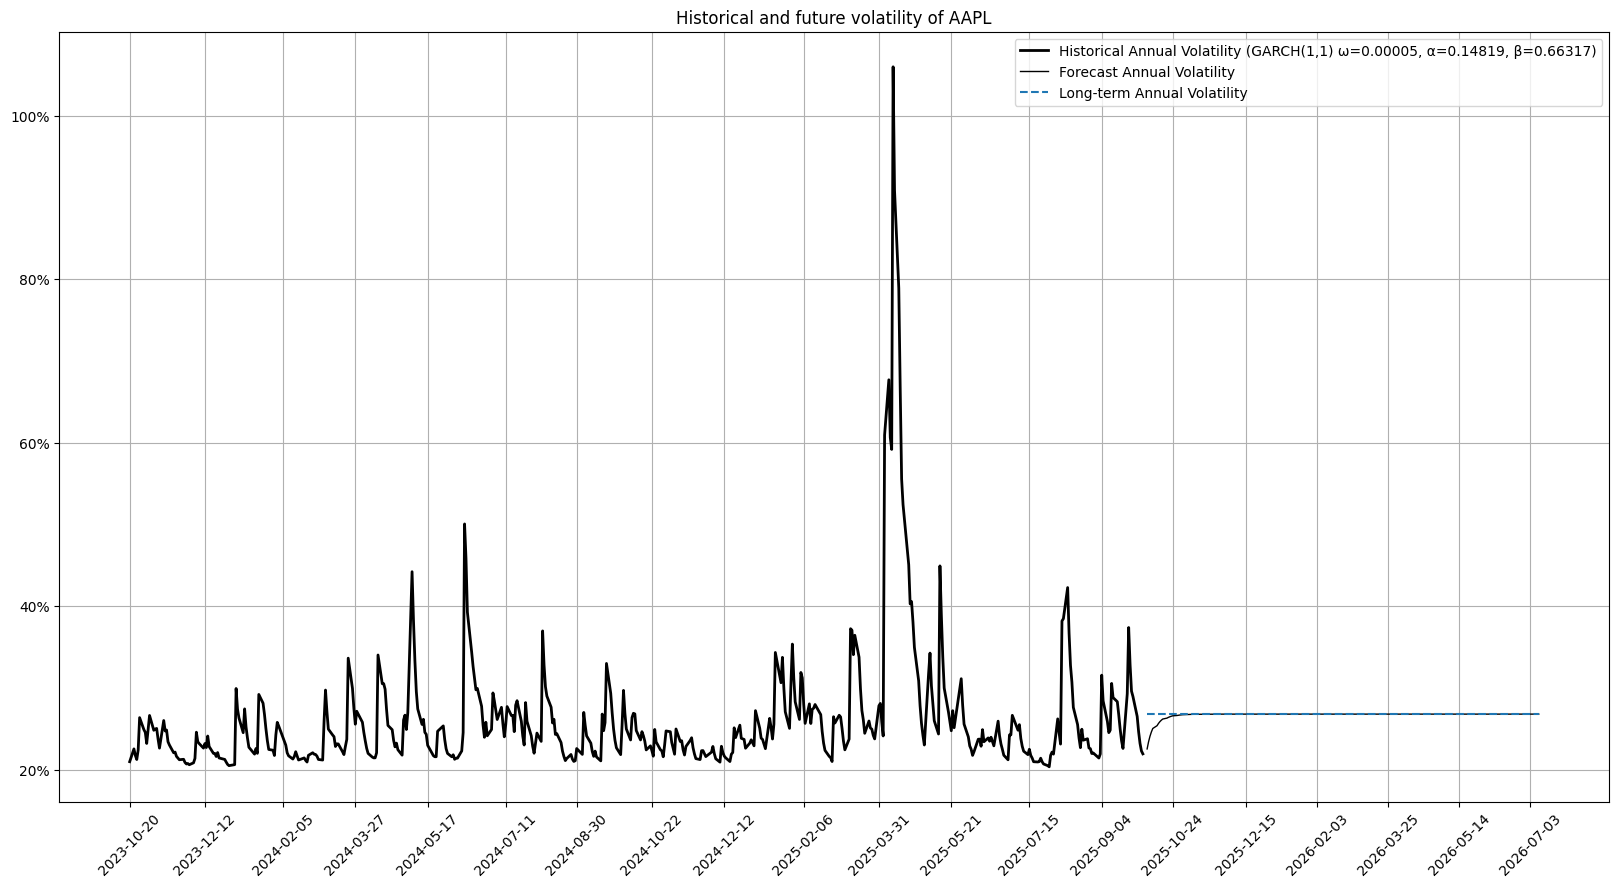

In [6]:
import matplotlib.pyplot as plt

# Skipping the first n days of volatility forecast
n_days_to_skip = 10
x = vol_tracker.get_dates()[n_days_to_skip:]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, vol_tracker.get_annual_volatilities()[n_days_to_skip:],
        label='Historical Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' 
            % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta),
        linewidth=2, color='k')

# Forecasting volatility of Apple stock 200 days into the future
future_volatilities = vol_tracker.get_annual_volatility_forecast_for_next_n_days(200)
ax.plot(future_volatilities.index, future_volatilities, label='Forecast Annual Volatility', linewidth=1, color='k')
ax.hlines(vol_tracker.get_annual_long_term_volatility(), xmin=future_volatilities.index[0], xmax=future_volatilities.index[-1],
         label="Long-term Annual Volatility", linestyle='--')
ax.legend()
ax.grid(True)
ax.set_title('Historical and future volatility of AAPL')
x_axis = x.append(future_volatilities.index)
ax.set_xticks(x_axis[::36])
ax.set_xticklabels(x_axis[::36].strftime('%Y-%m-%d'), rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

#### Optional: Visualizing the volatility term structure of Apple stock for 5 years into the future
A very important notion in pricing options is the _volatility term structure_. It defines the relationship between
the maturity of options and their volatilities. In other words it defines what the average volatility for a given maturity is forecast to be. Given the mean reverting nature of volatility, volatility for the longer terms trends towards the mean volatility of a given asset.

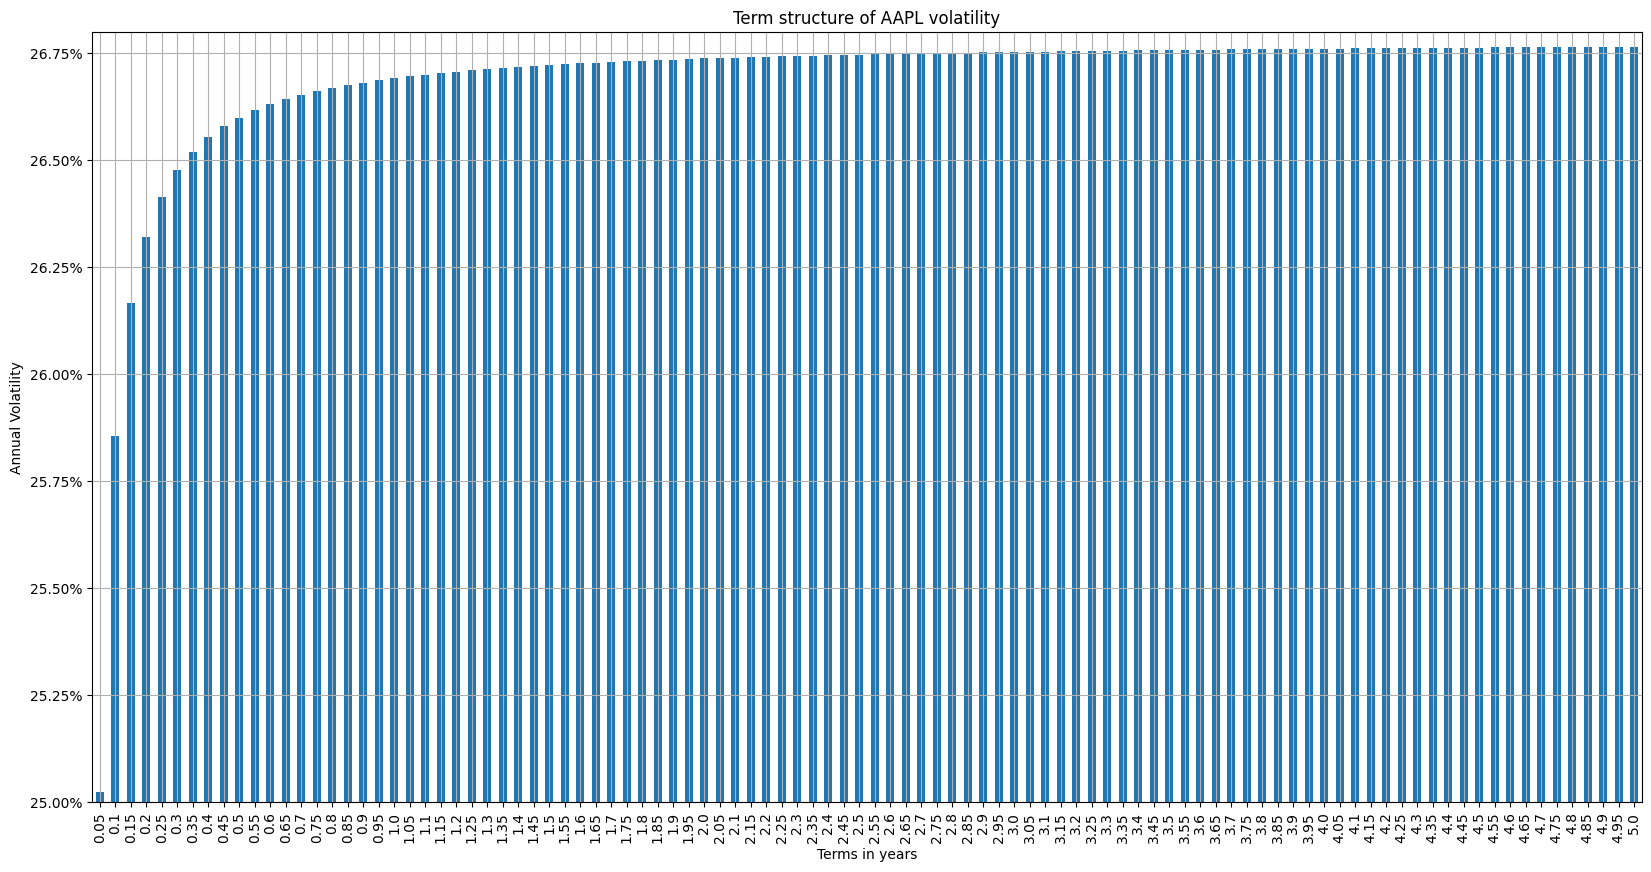

In [7]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of ' + TICKER + ' volatility')
ax.set_ylim(bottom=floor(series.min()*10) / 10, top=ceil(series.max()*10) / 10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including on stock that pays dividends. With enough customizations it can also be used to price American call options (even those paying dividends). This is based on the fact that it is never optimal to exercise an American call option prematurely except on days immediately preceeding ex-dividend days for the stock. The `pricing.options.BlackScholesMertonPricer` class from this repository implements this customization to price American call options.

Let's put it to use to price an AAPL call option with a strike of $180. Apple pays dividends. It's essential to take into account dividends that get payed during the lifetime of an option to get an accurate price.

Market makers tend to calculate the life time of options using trading days rather than calendar days. The `pricing.options.BlackScholesMertonPricer` class supports both ways of pricing options. It's determined by the `holidays` parameter of its constructor, passing an array of `datetime64[D]` values implies calculating the life of
the option using the number trading days to its expiry and dividing by 252. Not passing a value for this parameter
will imply calculating the life of the option using the number of calendar days to its expiry and dividing by a value between 365 and 366. It **does** make an impact of about 3\%-5\% on the price of the option depending on its maturity, for longer-dated options the impact is smaller. In the below notebook I price based on the trading
calendar of the New-York Stock Exchange. 

In [8]:
strike = 180.

# yfinance returns the most recent ex-dividend date in the last row
#ticker = yfin.Ticker(TICKER)
last_divs = ticker.dividends.iloc[-1:]

# An approximate rule for Apple's ex-dividend dates -- ex-dividend date is on the first Friday
# of the last month of a season if that Friday is the 5th day of the month or later, otherwise
# it falls on the second Friday of that month.
idx = (pd.date_range(last_divs.index[0].date(), freq='WOM-1FRI', periods=30)[::3])
idx = idx.map(lambda dt: dt if dt.day >= 5 else dt+BDay(5))
divs = pd.Series([last_divs.iloc[0]] * len(idx), index=idx, name=TICKER + ' Dividends')

# Taking the trading calendar into account when pricing
import pandas_market_calendars as mcal
holidays = mcal.get_calendar('NYSE').holidays().holidays

cur_price = asset_prices.iloc[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price, ticker=TICKER,
                                          dividends=divs, opt_type=options.OptionType.AMERICAN, holidays=holidays)
print(pricer)

AAPL AMERICAN call option with strike 180.0 and maturity 2026-01-16, price: 79.79, σ: 0.2646, Δ: 0.997, Γ: 0.000, ν: 1.402


Sometimes you might want to price using _an implied volatility_ for a given expiry date. You get the implied volatilty from the option prices of market makers. The `pricing.options.BlackScholesMertonPricer` class supports this. Just enter the implied volatility value instead of passing it a volatility_tracker object:

In [9]:
# Pricing with an implied volatility of 43.42% (implied volatility for this contract as of 15th Sep 2023)
pricer = options.BlackScholesMertonPricer(maturity_date, .4342, strike, curve, cur_price, ticker=TICKER,
                                          dividends=divs, opt_type=options.OptionType.AMERICAN, holidays=holidays)
print(pricer)

AAPL AMERICAN call option with strike 180.0 and maturity 2026-01-16, price: 80.87, σ: 0.4342, Δ: 0.957, Γ: 0.002, ν: 12.406


As you can see, a different volatility value resulted in a different price.

Let's now price an AAPL call option with a longer maturity. This is a little more complex as there are more ex-dividend dates during the option's lifetime.

In [10]:
maturity_date = curve.date + relativedelta(years=1, month=12, day=1, weekday=FR(3))
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price, ticker=TICKER,
                                          dividends=divs, opt_type=options.OptionType.AMERICAN, holidays=holidays)
print(pricer)

AAPL AMERICAN call option with strike 180.0 and maturity 2026-12-18, price: 86.73, σ: 0.2671, Δ: 0.935, Γ: 0.002, ν: 35.194


If you wonder where the volatility forecast came from, it came from the GARCH(1, 1) `vol_tracker` object I passed to the BlackScholesMertonPricer. You can easily see this:

In [11]:
vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))

0.2670704598451396

## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on stock that pays dividends.

Let's put it to use to price an AAPL call and put option with a strike of $180 and compare resulting prices for call options. The constructor of the `BinomialTreePricer` class takes exactly the same parameters as its
`BlackScholesMertonPricer` counterpart. I will use it using the trading calendar of the NYSE to calculate
the lifetime of options priced.

In [12]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, ticker=TICKER,
                                             dividends=divs, opt_type=options.OptionType.AMERICAN, holidays=holidays)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))

AAPL AMERICAN call option with strike 180.0 and maturity 2026-12-18, price: 86.65, σ: 0.2671, Δ: 0.936, Γ: 0.002, ν: 29.394
Price difference between Black-Scholes-Merton and Binomial Treee pricers: 0.082998


Let's now price an AAPL put option with the same maturity. You cannot price put options with a `BlackScholesMertonPricer`, with a `BinomialTreePricer` you can.

In [13]:
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN,
                                                 holidays=holidays)
print(bin_tree_pricer_put)

AAPL AMERICAN put option with strike 180.0 and maturity 2026-12-18, price: 2.42, σ: 0.2671, Δ: -0.066, Γ: 0.002, ν: 30.439


#### Put-Call Parity
An important theoretical property of the price of an American option is the so-called put-call parity, which is expressed as:
$$S_0 - D - K <= C - P <= S_0 - K\cdot e^{-r\cdot T}$$
where:
* C is the price of an American call option
* P is the price of the corresponding American put option
* S<sub>0</sub> is the present price of the underlying stock
* D is the present value of the dividents whose ex-dividend dates happen before the maturity date of the option
* K is the strike price
* T is the liefteime of the option expressed in years
* r is the riskless rate for maturity T

Let's put it to the test:

In [14]:
from math import exp
price_difference = bin_tree_pricer.get_price() - bin_tree_pricer_put.get_price()
left_hand_side_expr = bin_tree_pricer.s0 - bin_tree_pricer.get_npv_dividends() - bin_tree_pricer.strike
right_hand_side_expr = bin_tree_pricer.s0 - bin_tree_pricer.strike * exp(-bin_tree_pricer.r * bin_tree_pricer.T)

assert left_hand_side_expr <= price_difference <= right_hand_side_expr
print(f'Put-Call parity: {left_hand_side_expr:.2f} <= {price_difference:.2f} <= {right_hand_side_expr:.2f}')

Put-Call parity: 76.75 <= 84.23 <= 85.53


If you wish to price with a given implied volatility, just pass it to the pricer as the second parameter:

In [15]:
impl_vol = .3297
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, ticker=TICKER,
                                             dividends=divs, opt_type=options.OptionType.AMERICAN,
                                             holidays=holidays)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN,
                                                 holidays=holidays)
print(bin_tree_pricer_put)

AAPL AMERICAN call option with strike 180.0 and maturity 2026-12-18, price: 89.55, σ: 0.3297, Δ: 0.900, Γ: 0.002, ν: 49.856
AAPL AMERICAN put option with strike 180.0 and maturity 2026-12-18, price: 5.35, σ: 0.3297, Δ: -0.102, Γ: 0.002, ν: 50.213


## Pricing with your own discount curve
You might want to prefer to price using your own discount curve. The `YieldCurve` class of the `pricing.curves` package makes it fairly easy to do.

In [16]:
# Reusing 'relativedelta' offsets defined in Cell 3, which are for 0, 1 month, 3 months, 6 months, 1 year, 2 years,
# 3 years, 5 years, 7 years, 10 years, 20 years, 30 years.

# Defining a flat curve with a discount rate of 3% and yearly compounding frequency.
custom_curve = curves.YieldCurve(today, offsets, [.03]*len(offsets), compounding_freq=1)

Now pricing with out own flat curve and a given implied volatility:

In [17]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, custom_curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN,
                                             holidays=holidays)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, custom_curve, cur_price,
                                                 is_call=False, ticker=TICKER, dividends=divs,
                                                 opt_type=options.OptionType.AMERICAN, holidays=holidays)
print(bin_tree_pricer_put)

AAPL AMERICAN call option with strike 180.0 and maturity 2026-12-18, price: 88.55, σ: 0.3297, Δ: 0.896, Γ: 0.002, ν: 51.103
AAPL AMERICAN put option with strike 180.0 and maturity 2026-12-18, price: 5.56, σ: 0.3297, Δ: -0.105, Γ: 0.002, ν: 51.399
